In [1]:
import numpy as np
import scipy as sp
from supercell import *
from file_io import *

In [2]:
def view2d(xyz,P=False,c=None,title=None,s=None,cmap=None,with_num=False):
    import matplotlib.pyplot as plt
    if xyz.shape[1] == 2:
        plt.scatter(xyz[:,0],xyz[:,1],c=c,s=s,cmap=cmap)
    elif xyz.shape[1] == 3:
        plt.scatter(xyz[:,0],xyz[:,1],c=c,s=s,cmap=cmap)
    else:
        raise ValueError

    if with_num:
        labels = [f'{i+1}' for i in range(xyz.shape[0])]
        for i, label in enumerate(labels):
            plt.text(xyz[i,0],xyz[i,1],label)

    if type(P) == np.ndarray:
        a = P[0, :2]; b = P[1, :2]
        vertices = np.array([ [0,0], a, a+b, b, [0,0] ])
        plt.plot(vertices[:, 0], vertices[:, 1], '-o', color='blue')
        plt.fill(vertices[:, 0], vertices[:, 1], alpha=0.05, color='blue')
        plt.xlim(0,P[1,1])
        plt.ylim(P[0,1],P[0,0])

    if type(c) == np.ndarray:
        plt.colorbar()
    # plt.scatter(0,0,c='black')
    plt.title(title)
    plt.grid(True)
    plt.axis('scaled')
    # plt.show()

In [3]:
def honeycombe_grids(lattice,const=2.46,dim=2,reverse=False,center=0):
    n = int(np.max(np.abs(lattice/const)))+1
    l = np.linspace(-n+1,n,2*n)

    if center:
        A = np.meshgrid(l+center//6-1/6*center,l+center//2-1/2*center)
    else:
        A = np.meshgrid(l,l)

    X = np.array([A[0],A[0]-0.5]).flatten()*np.sqrt(3)
    Y = np.array([A[1],A[1]-0.5]).flatten()

    x = np.array([X+1/np.sqrt(3)*np.cos(i*np.pi/3) for i in range(2)]).flatten()
    y = np.array([Y+1/np.sqrt(3)*np.sin(i*np.pi/3) for i in range(2)]).flatten()

    if reverse:
        x,y = y,x

    if dim == 2:
        return np.array([x,y],dtype=float)*const
    elif dim == 3:
        return np.array([x,y,np.ones_like(x)],dtype=float)*const

In [4]:
def hexagonal_P(crystal=np.array([0,0,0]),hex=np.array([90,90,120]),vacuum_z=False):
    alpha,beta,gamma = np.deg2rad(hex)
    vector_a = crystal[0]*np.array([1,0,0])
    vector_b = crystal[1]*np.array([np.cos(gamma),np.sin(gamma),0])
    # vector_c = crystal[2]*np.array([np.cos(beta),(np.cos(alpha)-np.cos(beta)*np.cos(gamma))/np.sin(gamma),(1+2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)-np.cos(alpha)**2-np.cos(beta)**2-np.cos(gamma)**2)**0.5/np.sin(gamma)])
    vector_c = crystal[2]*np.array([0,0,1])
    P = np.row_stack((vector_a,vector_b,vector_c))
    P[2,2] = vacuum_z if vacuum_z else P[2,2]
    return P

In [5]:
class DoubleSpiral():
    def __init__(self, 
                 bvector=1,
                 nvaccum=0,
                 nlayers=6,
                 stack=1):
        
        self.bvector = bvector
        self.nvaccum = nvaccum
        self.nlayers = nlayers
        self.stack = stack
        
    def double_screw(self,N=15,save=False,save_dir='./'):
        from supercell import rotate, translate
        from numpy.linalg import inv as _inv

        def mobius_transfer(z,alpha=0,inverse=False):
            alpha = -alpha if inverse else alpha
            t_z = z/(1+alpha*z)
            return np.where(t_z == 0, 1e-10, t_z)

        pbcz = self.nlayers//self.bvector
        _d = 3.62 if self.stack == 1 else 3.35
        
        M = self.nlayers if pbcz else self.nlayers+5
        crystal_para = np.array([2.46,2.46,_d])*[N,N,M]
        P = hexagonal_P(crystal_para)
    
        x,y,z = [],[],[]
        theta = 2*np.pi/self.bvector
    
        if P[1,0] == 0:
            r_AB = P[0,0]/4
        else:
            r_AB = P[0,0]*np.sqrt(3)/6
    
        for l in range(pbcz):
            for b in range(self.bvector):
                grid = honeycombe_grids(P,dim=3,reverse=True,center=b%self.stack).T
                X,Y,Z = translate(rotate(grid,-30),[0,-P[0,0]/2,0]).T
    
                Z = (-(np.abs(X)-r_AB)+1j*Y)*np.exp(1j*theta*b)
                # Z = np.log((-(np.abs(X)-r_AB)+1j*Y)*np.exp(1j*theta*b)).imag
                # Z = np.angle((-(np.abs(X)-r_AB)+1j*Y)*(np.cos(theta*b)+1j*np.sin(theta*b)))
                Z = np.log(mobius_transfer(Z)).imag+2*np.pi*l
    
                x.append(X)
                y.append(Y)
                z.append(Z)
            # z.append(np.angle((x+1j*y)*(np.cos(np.pi/4)+1j*np.sin(np.pi/4)))+2*np.pi*l)
    
        x = np.array(x).flatten()
        y = np.array(y).flatten()
        z = (np.array(z).flatten()/np.pi+1)/2*_d*self.bvector
    
        xyz = np.c_[x,y,z]
        xyz = translate(rotate(translate(xyz,[0,P[0,0]/2,0]),30),[1e-12,1e-12,0])
        xyz = np.delete(xyz@_inv(P),np.where((xyz@_inv(P)>1)|(xyz@_inv(P)<0)),axis=0)@P
    
        if self.nvaccum:
            V1 = np.array([P[0,0]/2,P[0,0]/2/np.sqrt(3)])
            V2 = np.array([0, P[0,0]/np.sqrt(3)])
            d1 = np.sqrt((xyz[:,0]-V1[0])**2+(xyz[:,1]-V1[1])**2)
            d2 = np.sqrt((xyz[:,0]-V2[0])**2+(xyz[:,1]-V2[1])**2)
            xyz = xyz[(d1 > self.nvaccum*1.42+0.1) & (d2 > self.nvaccum*1.42+0.1)]
            # xyz = xyz[d1 > vacuum*1.42+0.1]
    
        self.conf = f'{save_dir}/N{N}_bv{self.bvector}_s{self.stack}_v{self.nvaccum}'
        data = DataFile(xyz,lattice='hex',P=P,f=self.conf)
        if save:
            data.write_xyz()
            data.write_lmp(ntype=self.bvector,split=self.bvector)
            data.write_poscar()
        
        return data.xyz

In [6]:
from make_Hex import make_hex,f_theta
class SingleSpiral:
    def __init__(self,
                 nlayers=1,
                 bvector=1,
                 nvacuum=0,
                 twisted=0,
                 shifted=False):

        self.nlayers = nlayers
        self.bvector = bvector
        self.nvacuum = nvacuum
        self.twisted = twisted
        self.shifted = shifted
        self.abs_bv = np.abs(self.bvector)

    def riemann_sheet(self,flat):
        x = flat[:,0]
        y = flat[:,1]
        z = np.zeros((self.nlayers, flat.shape[0]))

        height = 3.35*self.abs_bv if self.shifted else 3.62*self.abs_bv

        for k in range(self.nlayers):
            z[k] = np.angle(np.sign(self.bvector)*x+1j*y)+2*np.pi*k

        scale = height/(np.max(z[0])-np.min(z[0])) if self.nlayers==1 else height/(z[1,0]-z[0,0])

        x = np.tile(x,self.nlayers)
        y = np.tile(y,self.nlayers)
        z = z.reshape(self.nlayers*flat.shape[0])*scale
        return np.c_[x,y,z]

    def spiral_graphene(self,m=10,edge='armchair'):
        flat = make_hex(m,edge=edge)
        angle = f_theta(m) if self.twisted else 0

        print(f'twisted angle is: {angle:.2f}°, burgers vector is {self.bvector}, vacuum neighbor is {self.nvacuum}')

        sprial_0 = self.riemann_sheet(flat)

        sprial = []
        for i in range(np.abs(self.bvector)):
            sprial_i = rotate(sprial_0,360/self.abs_bv*i
                              +(angle*(i%2))*int(self.twisted))
            sprial.append(sprial_i)

        sprial = np.array(sprial)
        sprial = sprial.reshape(sprial.size//3,3)
                      
        d = np.sqrt((sprial[:,0]-0)**2+(sprial[:,1]-0)**2)
        sprial = sprial[d > self.nvacuum*1.42+0.1]

        return sprial


In [7]:
double = DoubleSpiral(bvector=2)
double_data = double.double_screw(N=9,save=True)

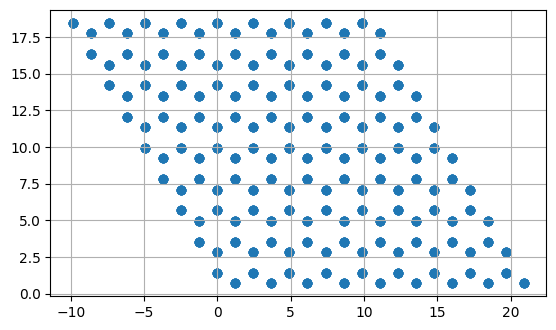

In [8]:
view2d(double_data)

In [28]:
m=6
single = SingleSpiral(bvector=1)
single_data = single.spiral_graphene(m=m)

twisted angle is: 0.00°, burgers vector is 1, vacuum neighbor is 0


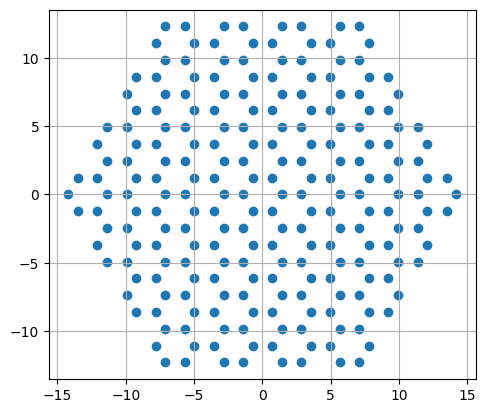

In [29]:
view2d(single_data)

In [30]:
data = DataFile(double_data,pbc=True)
data.write_poscar(f'./N{m}_b{single.bvector}_t{single.twisted}_v{single.nvacuum}_armchair')